# PART 2 TensorFlow
# 7. Workshop 5 : Batch Normalization for FCDNetworks
2019/09/23

[ Reference ]
+ Rui Shu, "**TENSORFLOW GUIDE: BATCH NORMALIZATION**", 2016/12/26. http://ruishu.io/2016/12/27/batchnorm/
    + Github code: https://github.com/RuiShu/micro-projects/blob/master/tf-batchnorm/batchnorm_guide.ipynb
+ Antoine Labatie, "**It’s Necessary to Combine Batch Norm and Skip Connections**", Towards Data Science, 2019/09/01. https://towardsdatascience.com/its-necessary-to-combine-batch-norm-and-skip-connections-e92210ca04da
+ Federico Peccia, "**Batch normalization: theory and how to use it with Tensorflow**", , Towards Data Science, 2018/09/16. https://towardsdatascience.com/batch-normalization-theory-and-how-to-use-it-with-tensorflow-1892ca0173ad

In [23]:
import numpy as np
import tensorflow as tf
print(tf.__version__)
# for the old-version usage of TensorFlow, such as tensorflow.examples.tutorials.mnist
old_v = tf.logging.get_verbosity()          
tf.logging.set_verbosity(tf.logging.ERROR) 

1.12.0


### Input MNIST dataset 

In [24]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [25]:
print(" mnist.train.images.shape :\t ", mnist.train.images.shape)
print(" mnist.train.labels.shape :\t ", mnist.train.labels.shape)
print(" mnist.validation.images.shape : ", mnist.validation.images.shape)
print(" mnist.validation.labels.shape : ", mnist.validation.labels.shape)
print(" mnist.test.images.shape :\t ", mnist.test.images.shape)
print(" mnist.test.labels.shape :\t ", mnist.test.labels.shape)

mnist.test.labels[0]

 mnist.train.images.shape :	  (55000, 784)
 mnist.train.labels.shape :	  (55000, 10)
 mnist.validation.images.shape :  (5000, 784)
 mnist.validation.labels.shape :  (5000, 10)
 mnist.test.images.shape :	  (10000, 784)
 mnist.test.labels.shape :	  (10000, 10)


array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

> + **[NOTE]: the `phase` term. **
    + useed as a **placeholder for a boolean** which we will insert into ``feed_dict`. 
    + It will serve as a binary indicator for whether we are in **training phase=True** or **testing phase=False** mode. 

In [26]:
def train_test():
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
    
    # --------------------------------------
    # Launch the computation graph...
    # --------------------------------------
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    history = []
    iterep = 500
    for i in range(iterep * 30):
        x_train, y_train = mnist.train.next_batch(100)
        sess.run(train_step,
                 feed_dict={'x:0': x_train, 
                            'y:0': y_train, 
                            'phase:0': 1})
        if (i + 1) %  iterep == 0:
            epoch = (i + 1)/iterep
            tr = sess.run([loss, accuracy], 
                          feed_dict={'x:0': mnist.train.images,
                                     'y:0': mnist.train.labels,
                                     'phase:0': 1})
            t = sess.run([loss, accuracy], 
                         feed_dict={'x:0': mnist.validation.images,
                                    'y:0': mnist.validation.labels,
                                    'phase:0': 0})
            history += [[epoch] + tr + t]
            print(history[-1])
            
    print("\n Computing the test accuracy ... ", end = " ")
    
    ##  ------------------------------------------------------------------
    ##  Test datasets...
    ##  ------------------------------------------------------------------
    test_loss = sess.run(loss, feed_dict={'x:0': mnist.test.images,
                                          'y:0': mnist.test.labels,
                                          'phase:0': 0})
    test_accu = sess.run(accuracy, feed_dict={'x:0': mnist.test.images,
                                              'y:0': mnist.test.labels,
                                              'phase:0': 0})
    print(" Done !!! ")
    
    return history, test_accu, test_loss

## < Case 1 > : No batch normalization

In [27]:
def dense(x, size, scope):
    return tf.contrib.layers.fully_connected(x, size, 
                                             activation_fn=None,
                                             scope=scope)

def dense_relu(x, size, scope):
    with tf.variable_scope(scope):
        h1 = dense(x, size, 'dense')
        return tf.nn.relu(h1, 'relu')

In [28]:
# Reset the default graph...
tf.reset_default_graph()

# -------------------------------
# Build a computation graph...
# -------------------------------
x = tf.placeholder('float32', (None, 784), name='x')
y = tf.placeholder('float32', (None, 10), name='y')
phase = tf.placeholder(tf.bool, name='phase')

# FCDNetwork with 2 hidden layers...
h1 = dense_relu(x, 100, 'layer1')
h2 = dense_relu(h1, 100, 'layer2')
logits = dense(h2, 10, scope='logits')

with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(y, 1), tf.argmax(logits, 1)), 
            'float32'))

with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))

In [29]:
history, test_accu, test_loss = train_test()

[1.0, 0.5974879, 0.8538727, 0.5853069, 0.859]
[2.0, 0.41201988, 0.8870909, 0.39432842, 0.8926]
[3.0, 0.3578257, 0.90003633, 0.33849472, 0.9058]
[4.0, 0.32537535, 0.9080727, 0.3076595, 0.912]
[5.0, 0.30692765, 0.9119273, 0.289903, 0.9152]
[6.0, 0.2878099, 0.9178727, 0.27251568, 0.9246]
[7.0, 0.27459642, 0.9206727, 0.26059717, 0.9276]
[8.0, 0.26177612, 0.9242909, 0.24766463, 0.9292]
[9.0, 0.25185537, 0.92776364, 0.23870158, 0.933]
[10.0, 0.2425021, 0.9299091, 0.23256025, 0.936]
[11.0, 0.23493825, 0.9319818, 0.2245039, 0.9364]
[12.0, 0.22571023, 0.9349091, 0.21745916, 0.9394]
[13.0, 0.2171985, 0.9376182, 0.2092188, 0.9412]
[14.0, 0.21022984, 0.9398909, 0.2034457, 0.944]
[15.0, 0.20354278, 0.94158185, 0.19700795, 0.9454]
[16.0, 0.19749208, 0.94323635, 0.19403903, 0.9458]
[17.0, 0.19057576, 0.9460545, 0.1873758, 0.9478]
[18.0, 0.18565452, 0.94667274, 0.18239795, 0.949]
[19.0, 0.17976035, 0.9486909, 0.17854421, 0.95]
[20.0, 0.17447284, 0.9505818, 0.17480348, 0.9514]
[21.0, 0.17097728, 0.9513

In [30]:
print(" [ Test  Accuracy ] : {}".format(test_accu) +
      "\n [ Test Loss Score ] : {}".format(test_loss))

 [ Test  Accuracy ] : 0.9596999883651733
 [ Test Loss Score ] : 0.14061963558197021


## < Case 2 > : Standard batch normalization
+ Batch normalization would be to simply use the `tf.contrib.layers.batch_norm layer`.
+ One thing that might stand out is the `phase` term. 
    + We are going to use as a **placeholder for a boolean** which we will insert into feed_dict. 
    + It will serve as a binary indicator for whether we are in **training phase=True** or **testing phase=False** mode. 
    
    
+ Recall that batch normalization has distinct behaviors during training verus test time:
> + Training
    1. Normalize layer activations according to mini-batch statistics.
    2. During the training step, update population statistics approximation via moving average of mini-batch statistics.
 + Testing
    1. Normalize layer activations according to estimated population statistics.
    2. Do not update population statistics according to mini-batch statistcs from test data.

In [31]:
def dense_batch_relu(x, phase, scope):
    with tf.variable_scope(scope):
        h1 = tf.contrib.layers.fully_connected(x, 100, activation_fn=None, scope='dense')
        
        # Batch normalization would be to simply use the tf.contrib.layers.batch_norm layer.
        h2 = tf.contrib.layers.batch_norm(h1, 
                                          center=True, scale=True, 
                                          is_training = phase,
                                          scope='bn')
        return tf.nn.relu(h2, 'relu')

In [32]:
# Reset the default graph...
tf.reset_default_graph()

# -------------------------------
# Build a computation graph...
# -------------------------------
x = tf.placeholder('float32', (None, 784), name='x')
y = tf.placeholder('float32', (None, 10), name='y')
phase = tf.placeholder(tf.bool, name='phase')

# FCDNetwork with 2 hidden layers...
h1 = dense_batch_relu(x, phase,'layer1')
h2 = dense_batch_relu(h1, phase, 'layer2')
logits = dense(h2, 10, 'logits')

with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(y, 1), tf.argmax(logits, 1)), 
            'float32'))

with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))

In [33]:
history_bn, test_accu_bn, test_loss_bn = train_test()

[1.0, 0.4029456, 0.89916366, 1.2113225, 0.8754]
[2.0, 0.28484067, 0.92423636, 0.7326332, 0.925]
[3.0, 0.2329334, 0.9365091, 0.43603402, 0.9388]
[4.0, 0.20110916, 0.94427276, 0.2932952, 0.9454]
[5.0, 0.17876229, 0.95034546, 0.22216599, 0.9504]
[6.0, 0.16131903, 0.95567274, 0.18820561, 0.9522]
[7.0, 0.14722604, 0.9590182, 0.16359887, 0.9562]
[8.0, 0.13537055, 0.9629091, 0.15405343, 0.9562]
[9.0, 0.12557305, 0.9652909, 0.14074719, 0.9608]
[10.0, 0.11694494, 0.96778184, 0.13405979, 0.9616]
[11.0, 0.10895554, 0.97047275, 0.124634616, 0.967]
[12.0, 0.10207596, 0.9722546, 0.12112635, 0.9652]
[13.0, 0.09595783, 0.9738909, 0.11571294, 0.9676]
[14.0, 0.09040919, 0.97581816, 0.11031676, 0.97]
[15.0, 0.08512994, 0.97776365, 0.109445006, 0.9694]
[16.0, 0.08048531, 0.97914547, 0.10421537, 0.972]
[17.0, 0.076266155, 0.97996366, 0.1016766, 0.9732]
[18.0, 0.072354116, 0.9814909, 0.09955831, 0.9738]
[19.0, 0.06875713, 0.98210907, 0.09622032, 0.9746]
[20.0, 0.0652389, 0.9832364, 0.09394018, 0.975]
[21.0,

In [34]:
print(" << With Batch Normalization >> :")
print(" [ Test  Accuracy ] : {}".format(test_accu_bn) +
      "\n [ Test Loss Score ] : {}".format(test_loss_bn))

print("\n < Without Batch Normalization > :")
print(" [ Test  Accuracy ] : {}".format(test_accu) +
      "\n [ Test Loss Score ] : {}".format(test_loss))

 << With Batch Normalization >> :
 [ Test  Accuracy ] : 0.9732000231742859
 [ Test Loss Score ] : 0.08438501507043839

 < Without Batch Normalization > :
 [ Test  Accuracy ] : 0.9596999883651733
 [ Test Loss Score ] : 0.14061963558197021


## < Case 3 > : Post-activation batch normalization

In [35]:
def dense_relu_batch(x, phase, scope):
    with tf.variable_scope(scope):
        h1 = dense_relu(x, 100, scope='dense_relu')
        
        ##  Post-activation batch normalization...
        bn = tf.contrib.layers.batch_norm(h1, 
                                          center=True, scale=True, 
                                          is_training=phase,
                                          scope='bn')
        return bn

In [36]:
tf.reset_default_graph()
x = tf.placeholder('float32', (None, 784), name='x')
y = tf.placeholder('float32', (None, 10), name='y')
phase = tf.placeholder(tf.bool, name='phase')

h1 = dense_relu_batch(x, phase,'layer1')
h2 = dense_relu_batch(h1, phase, 'layer2')
logits = dense(h2, 10, 'logits')

with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(y, 1), tf.argmax(logits, 1)), 
            'float32'))

with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))

In [37]:
history_post_bn, test_accu_post_bn, test_loss_post_bn = train_test()

[1.0, 0.29440942, 0.91865456, 1.2764627, 0.8408]
[2.0, 0.21527319, 0.9402182, 0.84999573, 0.903]
[3.0, 0.17682013, 0.9511273, 0.53688824, 0.9258]
[4.0, 0.15151712, 0.95772725, 0.3459156, 0.9414]
[5.0, 0.1336288, 0.9636, 0.23691347, 0.9532]
[6.0, 0.119532704, 0.96714544, 0.18387112, 0.9576]
[7.0, 0.10871756, 0.97047275, 0.15176688, 0.9624]
[8.0, 0.099558525, 0.97294545, 0.13328493, 0.9636]
[9.0, 0.091594175, 0.97534543, 0.12442992, 0.9644]
[10.0, 0.08491094, 0.9774182, 0.11621247, 0.9652]
[11.0, 0.0786337, 0.97943634, 0.11166791, 0.9654]
[12.0, 0.073562734, 0.9805091, 0.10907227, 0.9668]
[13.0, 0.06918399, 0.9818364, 0.105893664, 0.968]
[14.0, 0.06446469, 0.98309094, 0.10265437, 0.9694]
[15.0, 0.060493488, 0.98416364, 0.10159227, 0.9694]
[16.0, 0.05706358, 0.9850909, 0.09932703, 0.9708]
[17.0, 0.053565256, 0.98627275, 0.0972843, 0.9698]
[18.0, 0.050590012, 0.9872182, 0.09649276, 0.9714]
[19.0, 0.04832869, 0.9876364, 0.09446684, 0.9716]
[20.0, 0.045114234, 0.9888909, 0.09514804, 0.9712]


In [38]:
print(" <<< Post-activation Batch Normalization >>> :")
print(" [ Test  Accuracy ] : {}".format(test_accu_post_bn) +
      "\n [ Test Loss Score ] : {}".format(test_loss_post_bn))

print(" << With Batch Normalization >> :")
print(" [ Test  Accuracy ] : {}".format(test_accu_bn) +
      "\n [ Test Loss Score ] : {}".format(test_loss_bn))

print("\n < Without Batch Normalization > :")
print(" [ Test  Accuracy ] : {}".format(test_accu) +
      "\n [ Test Loss Score ] : {}".format(test_loss))

 <<< Post-activation Batch Normalization >>> :
 [ Test  Accuracy ] : 0.9729999899864197
 [ Test Loss Score ] : 0.08636382222175598
 << With Batch Normalization >> :
 [ Test  Accuracy ] : 0.9732000231742859
 [ Test Loss Score ] : 0.08438501507043839

 < Without Batch Normalization > :
 [ Test  Accuracy ] : 0.9596999883651733
 [ Test Loss Score ] : 0.14061963558197021


## Evaluation

In [39]:
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [40]:
history = np.array(history)
history_bn = np.array(history_bn)
history_post_bn = np.array(history_post_bn)

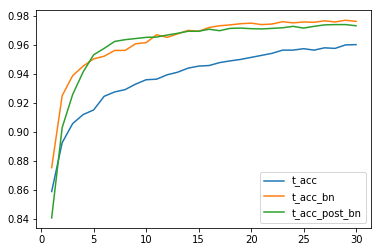

In [41]:
plt.plot(history[:, 0], history[:, -1], label='t_acc')
plt.plot(history_bn[:, 0], history_bn[:, -1], label='t_acc_bn')
plt.plot(history_post_bn[:, 0], history_post_bn[:, -1], label='t_acc_post_bn')
plt.legend()

### As you can see, batch normalization really does help with training (not always, but it certainly did in this simple example).